In [39]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

from tubesml.base import BaseTransformer, self_columns, reset_columns
import tubesml as tml

from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from sklearn.preprocessing import PolynomialFeatures, LabelEncoder

from source import explore as ex
from source import utility as ut
from source.train import train_model
from source.report import plot_regression_predictions, plot_learning_curve, plot_feat_imp, plot_partial_dependence

import lightgbm as lgb

pd.set_option('max_columns', 100)

In [40]:
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')
subs = pd.read_csv('data/sample_submission.csv')

In [41]:
train_set, test_set = ut.make_test(df_train, 0.25, random_state=516, strat_feat='cat9')

del train_set['id']
del test_set['id']

y = train_set['target'].copy()
del train_set['target']
y_test = test_set['target'].copy()
del test_set['target']

folds = KFold(10, shuffle=True, random_state=541)

le_train = train_set.copy()
le_test = test_set.copy()

for col in [col for col in train_set if 'cat' in col]:
    le = LabelEncoder()
    le_train[col] = le.fit_transform(le_train[col])
    le_test[col] = le.transform(le_test[col])

In [30]:
class PolynomialDf(BaseTransformer):
    def __init__(self, degree=2, interaction_only=False, include_bias=False, to_interact='all'):
        super().__init__()
        self.degree = degree
        self.interaction_only = interaction_only
        self.include_bias = include_bias
        self.pol = PolynomialFeatures(degree=self.degree, 
                                      include_bias=self.include_bias, 
                                      interaction_only=self.interaction_only)
        self.to_interact = to_interact
    
    @reset_columns
    def fit(self, X, y=None):
        
        if self.to_interact == 'all':
            cols = X.columns
        else:
            cols = self.to_interact
        
        self.pol.fit(X[cols])
        
        return self
        
    @self_columns
    def transform(self, X, y=None):
        
        if self.to_interact == 'all':
            X_tr = self.pol.transform(X)
            X_tr = pd.DataFrame(X_tr, columns=self.pol.get_feature_names(X.columns), index=X.index)
        else:
            X_int = self.pol.transform(X[self.to_interact])
            X_int = pd.DataFrame(X_int, columns=self.pol.get_feature_names(self.to_interact), index=X.index)
            X_tr = pd.concat([X[[col for col in X if col not in self.to_interact]], X_int], axis=1)
        
        return X_tr

In [31]:
pol = PolynomialDf(to_interact=['cont2', 'cont4', 'cont5'])

tmp = pol.fit_transform(train_set[[col for col in train_set if 'cont' in col]])

tmp

,cont0,cont1,cont3,cont6,cont7,cont8,cont9,cont10,cont11,cont12,cont13,cont2,cont4,cont5,cont2^2,cont2 cont4,cont2 cont5,cont4^2,cont4 cont5,cont5^2
217278,0.992968,0.062644,0.771707,0.477072,0.777355,0.894772,0.832945,0.528586,0.712178,0.876089,0.594609,0.137455,0.494401,0.889793,0.018894,0.067958,0.122307,0.244432,0.439915,0.791732
168076,0.706340,0.297613,0.685358,0.875379,0.650188,0.210627,0.543731,0.551951,0.821223,0.898238,0.422612,0.574490,0.280016,0.980636,0.330039,0.160867,0.563365,0.078409,0.274594,0.961646
85899,0.735604,0.770009,0.561776,0.828429,0.345399,0.901242,0.759109,0.726503,0.637654,0.901267,0.729128,0.350257,0.266121,0.918674,0.122680,0.093211,0.321772,0.070820,0.244478,0.843962
66230,0.855760,0.617747,0.218510,0.304368,0.676240,0.862597,0.153856,0.177909,0.848022,0.311321,0.766169,0.145037,0.677832,0.520412,0.021036,0.098311,0.075479,0.459456,0.352752,0.270829
202344,0.397990,0.069838,0.174816,0.349109,0.702810,0.304682,0.441488,0.240995,0.381703,0.302658,0.719237,0.452991,0.775703,0.305720,0.205201,0.351386,0.138488,0.601714,0.237148,0.093465
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
189418,0.798052,0.082299,0.213995,0.476974,0.655777,0.912206,0.335450,0.489780,0.695984,0.773961,0.400255,0.228620,0.278574,0.924641,0.052267,0.063688,0.211392,0.077604,0.257581,0.854960
221491,0.889304,0.755799,0.768737,0.641231,0.677215,0.912487,0.824577,0.731298,0.725342,0.839305,0.348351,0.195522,0.276926,0.815591,0.038229,0.054145,0.159466,0.076688,0.225858,0.665188
173310,0.460129,0.357827,0.237589,0.535973,0.588046,0.059769,0.572049,0.367095,0.590918,0.329732,0.281500,0.426976,0.321281,0.333734,0.182309,0.137179,0.142496,0.103221,0.107222,0.111378
293109,0.146824,0.105136,0.439871,0.302747,0.814853,0.304654,0.406308,0.248042,0.291358,0.356092,0.373244,0.730053,0.282676,0.611917,0.532977,0.206369,0.446732,0.079906,0.172975,0.374443


In [45]:
numeric_pipe = Pipeline([('fs', tml.DtypeSel('numeric')), 
                         ('pol', PolynomialDf(degree=2))])


cat_pipe = Pipeline([('fs', tml.DtypeSel('category')),
                     ('dummies', tml.Dummify(match_cols=True, drop_first=True))])


processing_pipe = tml.FeatureUnionDf(transformer_list=[('cat_pipe', cat_pipe),
                                                 ('num_pipe', numeric_pipe)])


full_pipe = Pipeline([('processing', numeric_pipe), 
                      ('scaler', tml.DfScaler())])

Iteations for early stopping: [1857, 1727, 1488, 2149, 1752, 1656, 2233, 1780, 1935, 1672]
	Train set RMSE: 0.8447
	Test set RMSE: 0.8445


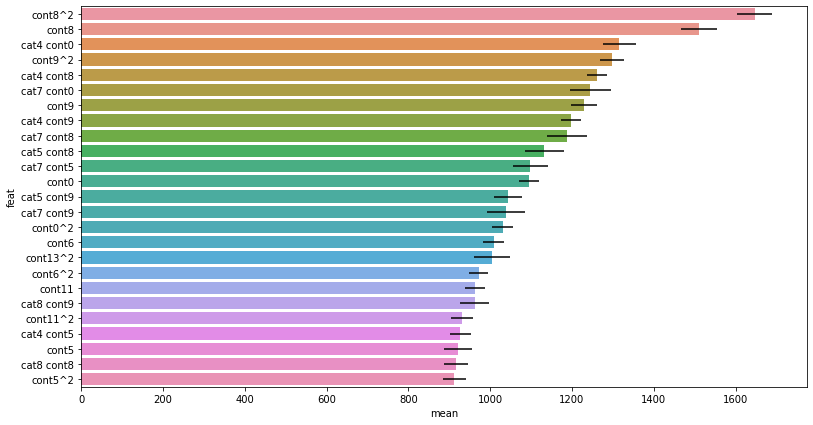

In [46]:
params = { 'reg_lambda': 0.016, 
          'reg_alpha': 9.1, 
          'colsample_bytree': 0.3, 
          'subsample': 1.0, 
          'learning_rate': 0.009, 
          'max_depth': 15, 
          'min_child_samples': 142, 
          'num_leaves': 84, 
          'random_state': 42}

mod = lgb.LGBMRegressor(n_estimators=5000, **params)

oof, pred, rep_res = train_model(le_train, le_test, y, full_pipe, mod, folds, early_stopping=500, verbose=False)

print(f'Iteations for early stopping: {rep_res["n_iterations"]}')

print(f'\tTrain set RMSE: {round(np.sqrt(mean_squared_error(y, oof)), 4)}')
print(f'\tTest set RMSE: {round(np.sqrt(mean_squared_error(y_test, pred)), 4)}')

plot_feat_imp(rep_res['feat_imp'], 25)

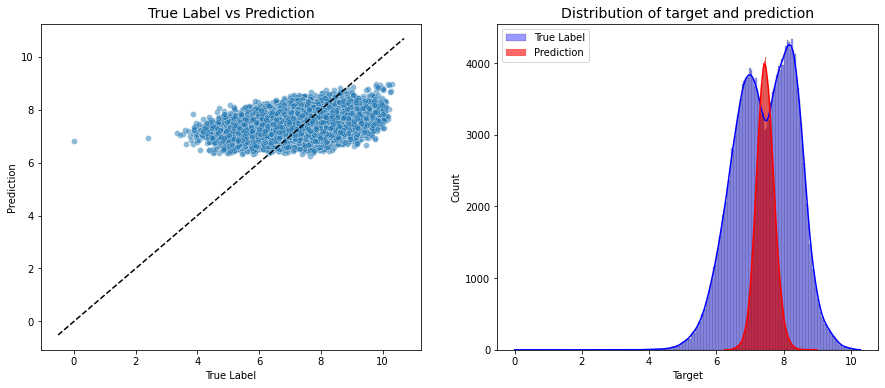

In [47]:
plot_regression_predictions(train_set, y, oof)

* cont8 w/ cat5, cat8, cat2, cat0
* cont1 w/ cat0
* cat1 w/ cont5, cont13
* cont6 w/ cat8
* cont9 w/ cat9, cat0, cont12, cat5
* cont11 w/ cat8
* cont14 w/ cat0

In [10]:
full_pipe.fit(train_set)
feats = full_pipe.steps[-2][1].get_feature_names()